### CSC427 Quantum Day Three

_Date: April 26, 2022_

_Author: Burton Rosenberg_


References, 

- https://qiskit.org/textbook/ch-algorithms/grover.html#3qubits
- C. Figgatt, D. Maslov, K. A. Landsman, N. M. Linke, S. Debnath & C. Monroe (2017), "Complete 3-Qubit Grover search on a programmable quantum computer", Nature Communications, Vol 8, Art 1918, doi:10.1038/s41467-017-01904-7, arXiv:1703.10535 
- https://arxiv.org/abs/1703.10535
- https://quantum-computing.ibm.com/composer/docs/iqx/guide/advanced-single-qubit-gates



In [1]:
import qiskit
import time, math

from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.jobstatus import JOB_FINAL_STATES, JobStatus
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

qiskit.__qiskit_version__

#initialization
import matplotlib.pyplot as plt
import numpy as np

# what is this?
from qiskit.providers.ibmq import least_busy

args_g = []

# your api token from IBM, first time run.
# after that None is good

#api_token = 'abcdefghijklmnopqrstuvwxyz'
api_token = None 

def load_or_save_IBMQ_account(api_token=None):
    global args_g
    print('getting provider...')
    if api_token:
        # only needs to be done once
        # then is stored in e.g. ~/.qistkit/qiskitrc
        IBMQ.save_account(api_token)
    provider = IBMQ.load_account()
    return provider

def list_backends(provider):
    global args_g
    print('backends available ...')
    backends = provider.backends()
    for be in backends:
        st = be.status()
        if st.operational:
            print(f'\t{be.name()}, pending jobs:{st.pending_jobs}')

            
def run_quantum_circuit_on_backend(quantum_circuit,provider,backend):
    backend = provider.get_backend(backend)
    qobj = assemble(transpile(quantum_circuit, backend=backend), backend=backend)
    job = backend.run(qobj)
    return job


def wait_for_job(backend, job, wait_interval=5):
    backend = provider.get_backend(backend)
    retrieved_job = backend.retrieve_job(job.job_id())
    start_time = time.time()
    job_status = job.status()
    while job_status not in JOB_FINAL_STATES:
        print(f'Status @ {time.time() - start_time:0.0f} s: {job_status.name},'
              f' est. queue position: {job.queue_position()}')
        time.sleep(wait_interval)
        job_status = job.status()


provider = load_or_save_IBMQ_account(api_token)
list_backends(provider)

# choose your backend

backend = 'ibmq_qasm_simulator'
#backend = 'ibmq_armonk'
#backend = 'ibmq_vigo'
#backend = 'ibmq_london'
#backend = 'ibmq_lima'

# and so forth ... chose from the results given by provider.backends()

getting provider...
backends available ...
	ibmq_qasm_simulator, pending jobs:3
	ibmq_armonk, pending jobs:6
	ibmq_santiago, pending jobs:51
	ibmq_bogota, pending jobs:73
	ibmq_lima, pending jobs:1
	ibmq_belem, pending jobs:5
	ibmq_quito, pending jobs:12
	simulator_statevector, pending jobs:2
	simulator_mps, pending jobs:2
	simulator_extended_stabilizer, pending jobs:1
	simulator_stabilizer, pending jobs:1
	ibmq_manila, pending jobs:31


In [2]:
# grover on 3

n = 4
grover_circuit = QuantumCircuit(n)

# |1> to flip sign
grover_circuit.x(3)
grover_circuit.barrier()
# superimpose all inputs
for i in range(n):
    grover_circuit.h(i)

grover_circuit.barrier()

# start of oracle
grover_circuit.x(0)
grover_circuit.mct([0,1,2],3)
grover_circuit.x(0)
# end of oracle

grover_circuit.barrier()

# start of amplification
for i in range(n):
    grover_circuit.h(i)
for i in range(n-1):
    grover_circuit.x(i)
# synthesize a controlled z
grover_circuit.h(2)
grover_circuit.mcx([0,1],2)
grover_circuit.h(2)
# controlled z synthesized
grover_circuit.barrier()
for i in range(n-1):
    grover_circuit.x(i)
for i in range(3):
    grover_circuit.h(i)
# end of amplification
    
grover_circuit.measure_all()
grover_circuit.draw()



░ ┌───┐ ░ ┌───┐     ┌───┐ ░ ┌───┐┌───┐                ░ ┌───┐»
   q_0: ──────░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├┤ X ├───────■────────░─┤ X ├»
              ░ ├───┤ ░ └───┘  │  └───┘ ░ ├───┤├───┤       │        ░ ├───┤»
   q_1: ──────░─┤ H ├─░────────■────────░─┤ H ├┤ X ├───────■────────░─┤ X ├»
              ░ ├───┤ ░        │        ░ ├───┤├───┤┌───┐┌─┴─┐┌───┐ ░ ├───┤»
   q_2: ──────░─┤ H ├─░────────■────────░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░─┤ X ├»
        ┌───┐ ░ ├───┤ ░      ┌─┴─┐      ░ ├───┤└───┘└───┘└───┘└───┘ ░ └───┘»
   q_3: ┤ X ├─░─┤ H ├─░──────┤ X ├──────░─┤ H ├─────────────────────░──────»
        └───┘ ░ └───┘ ░      └───┘      ░ └───┘                     ░      »
meas: 4/═══════════════════════════════════════════════════════════════════»
                                                                           »
«        ┌───┐ ░ ┌─┐         
«   q_0: ┤ H ├─░─┤M├─────────
«        ├───┤ ░ └╥┘┌─┐      
«   q_1: ┤ H ├─░──╫─┤M├──────
«        ├───┤ ░  ║ └╥┘┌─┐   
«   q_2: ┤ H ├─░──╫──╫─┤M├───
«        └───┘ ░  ║  ║ └╥┘┌─┐
«   q_3: ──────░──╫──╫──╫─┤M├
«              ░  ║  ║  ║ └╥┘
«meas: 4/═════════╩══╩══╩══╩═
«                 0  1  2  3

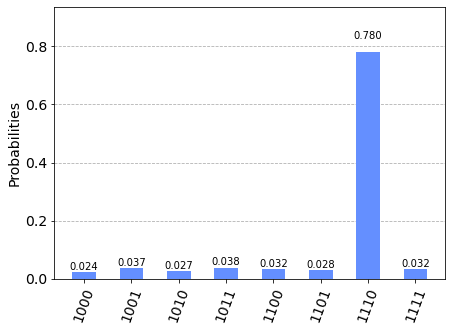

In [3]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

results: waiting for results from backend ibmq_lima ...


/var/folders/x7/99kj7q8d23966f07qr0q71bm0000gn/T/ipykernel_6317/4015517084.py:51: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


Status @ 0 s: VALIDATING, est. queue position: None
Status @ 5 s: RUNNING, est. queue position: None
Status @ 11 s: RUNNING, est. queue position: None
results: {'0000': 28, '0001': 26, '0010': 19, '0011': 24, '0100': 27, '0101': 16, '0110': 39, '0111': 17, '1000': 69, '1001': 108, '1010': 88, '1011': 63, '1100': 89, '1101': 58, '1110': 300, '1111': 53}


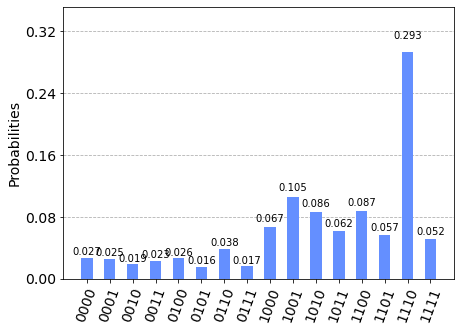

In [4]:

backend = 'ibmq_lima'   # ibmq_lima, ibmq_belem, ibmq_qasm_simulator

print(f'results: waiting for results from backend {backend} ...')
job = run_quantum_circuit_on_backend(grover_circuit,provider,backend)
wait_for_job(backend, job)
result = job.result()
print(f'results: {result.get_counts()}')
plot_histogram(result.get_counts())